In [ ]:
%%capture
!pip install sentence_transformers langchain_groq spacy weaviate-client langchain langchain_community langgraph tavily-python bs4

In [ ]:
from langchain_groq import ChatGroq
from sentence_transformers import SentenceTransformer
import os
import getpass
import weaviate

In [ ]:
%%capture
embedding_model = SentenceTransformer('dangvantuan/vietnamese-embedding', device='cpu')

In [ ]:
import weaviate
from weaviate.classes.init import Auth
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env("LANGCHAIN_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("WEAVIATE_URL")
_set_env("WEAVIATE_API_KEY")
_set_env("GROQ_API_KEY")


os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "QA-answering"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"

# client = weaviate.connect_to_weaviate_cloud(
#     cluster_url=WEAVIATE_URL,
#     auth_credentials=Auth.api_key(WEAVIATE_API_KEY),
# )

client = weaviate.Client(WEAVIATE_URL,
                        weaviate.auth.AuthApiKey(api_key=WEAVIATE_API_KEY))

In [ ]:

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0,
    max_tokens=1024,
    timeout=None,
    max_retries=2)

llm_json_mode = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0,
    max_tokens=1024,
    timeout=None,
    response_format={"type": "json_object"})

/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:362: UserWarning: WARNING! response_format is not default parameter.
                    response_format was transferred to model_kwargs.
                    Please confirm that response_format is what you intended.
  warnings.warn(


In [ ]:
from langchain.schema import Document
from weaviate.classes.query import MetadataQuery
# Truy vấn
def search(query,k):
  query_embedding = embedding_model.encode(query)
  result =(
    client.query
    .get("Document", ["title","content"])
    .with_hybrid(
        query=query,
        vector=query_embedding
    )
    .with_limit(k)
    .do()
)
  docs=[]
  
  for content in result["data"]["Get"]["Document"]:
    docs.append(Document(page_content= content['content']))
  return docs

#docs = search("Điểm GPA 3.3 thì xếp loại gì",10)
#docs

In [ ]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
import json

# Post-processing
def format_docs(docs):
    print(docs)
    return "\n\n".join(doc.page_content for doc in docs)

chat_awnswer = ""

In [ ]:
rag_prompt = """Bạn là một cố vấn học tập cho nhiệm vụ trả lời câu hỏi và giao tiếp sinh viên Đại học Bách khoa (ĐHBK) Hà Nội.

Nếu là câu hỏi, thì hãy xem xét các yêu cầu sau
Ngữ cảnh từ hội thoại:
"{summary}"
Ngữ cảnh từ tài liệu của đại học:
"{context}"
Ngữ cảnh từ web:
"{web_context}"
Bây giờ, hãy xem câu hỏi của người dùng:
"{question}?"
Hãy dành thời gian suy nghĩ kỹ (nhất là các câu về số) ngữ cảnh trên, ta cần ưu tiên ngữ cảnh từ tài liệu của đại học và hội thoại, sau đó mới cung cấp câu trả lời cho câu hỏi này.
Giữ cho câu trả lời ngắn gọn, dễ hiểu, phù hợp với đối tượng sinh viên, mở đầu bằng tôi sẽ giải đáp câu hỏi, tiếp theo là trả lời câu hỏi và kết thúc việc hỏi sinh viên còn câu hỏi nào không.
Lưu ý trả lời là Đại học Bách khoa Hà Nội, không có chữ trường.
Trả lời:
"""
choice_prompt = """
Bạn là một cố vấn học tập cho nhiệm vụ trả lời câu hỏi và giao tiếp sinh viên Đại học Bách khoa (ĐHBK) Hà Nội.

Nếu là câu hỏi, thì hãy xem xét các yêu cầu sau
Ngữ cảnh từ tài liệu của đại học:
"{context}"
Ngữ cảnh từ web:
"{web_context}"
Bây giờ, hãy xem câu hỏi của người dùng:
"{question}?"
Hãy suy nghĩ kỹ sau đó mới cung cấp câu trả lời cho câu hỏi này chỉ bằng ngữ cảnh trên chỉ bằng các chữ A,B,C,D là phương án và có giải thích thật ngắn gọn, không lặp lại. Nếu không biết đáp án chỉ cần ghi "Không biết".
Trả lời:
"""

router_instruction = """Bạn là chuyên gia trong việc định tuyến câu hỏi của người dùng đến vectorstore hoặc tìm kiếm trên web hoặc giao tiếp thông thường.
Vectorstore chứa các tài liệu liên quan đến quy định và học tập của Đại học Bách khoa Hà Nội (ĐHBKHN).
Sử dụng vectorstore cho các câu hỏi về các chủ đề này. Đối với tất cả các chủ đề khác, và đặc biệt là các sự kiện hiện tại, hãy sử dụng web-search. Đối với câu giao tiếp thông thường hãy sử dụng normal-conversation.
Và hãy dựa thêm bản tóm tắt hội thoại sau để quyết định xem câu nói có liên quan đến tóm tắt không: "{summary}".
Trả về JSON với khóa duy nhất là 'source' có giá trị chỉ gồm 'websearch' hoặc 'vectorstore' tùy thuộc vào câu hỏi (Nếu là câu giao tiếp thông thường thì trả về 'normal-conversation')"""

normal_conversation_instruction = "Bạn là cố vấn học tập của Đại học Bách khoa Hà Nội, khi gặp các câu giao tiếp thông thường nhớ nói bạn là ai và sẵn sàng giúp đỡ nhé! Lưu ý là đại học chứ không phải trường đại học nhé"

doc_grader_instructions = """Bạn là người chấm điểm đánh giá mức độ liên quan của một tài liệu đã truy xuất đến câu hỏi của người dùng.
Nếu tài liệu chứa từ khóa hoặc ý nghĩa ngữ nghĩa liên quan đến câu hỏi, hãy chấm điểm là có liên quan."""

doc_grader_prompt = """Đây là tài liệu đã truy xuất: \n\n {document} \n\n Đây là câu hỏi của người dùng: \n\n {question}?.
Kết hợp với bản tóm tắt hội thoại: "{summary}". Đánh giá cẩn thận và khách quan xem tài liệu có chứa thông tin liên quan đến câu hỏi và hội thoại hay không.
Trả về JSON với khóa "binary_score" là đánh giá chỉ gồm 'YES' hoặc 'NO' để xem liệu tài liệu có chứa thông tin liên quan đến câu hỏi hay không và một khoá giải thích tại sao."""

hallucination_grader_instructions = """
Bạn là giáo viên chấm bài kiểm tra.
Bạn sẽ được cung cấp SỰ THẬT và CÂU TRẢ LỜI CỦA HỌC SINH.
Sau đây là tiêu chí chấm điểm cần tuân theo:

(1) Đảm bảo CÂU TRẢ LỜI CỦA HỌC SINH dựa trên SỰ THẬT.
(2) Đảm bảo CÂU TRẢ LỜI CỦA HỌC SINH không chứa thông tin "ảo giác" nằm ngoài phạm vi của SỰ THẬT.

Điểm:
Điểm 'YES' có nghĩa là câu trả lời của học sinh đáp ứng tất cả các tiêu chí. Đây là điểm cao nhất (tốt nhất).
Điểm 'NO' có nghĩa là câu trả lời của học sinh không đáp ứng tất cả các tiêu chí. Đây là điểm thấp nhất có thể mà bạn có thể cho.
"""

hallucination_grader_prompt = """Văn bản từ đại học: \n\n {documents} \n {websearch} \n\n Câu trả lời của học sinh: {generation}.

Trả về JSON với hai khóa, binary_score là điểm 'YES' hoặc 'NO' để xem liệu CÂU TRẢ LỜI CỦA HỌC SINH có dựa trên văn bản hay không."""

answer_grader_instructions = """Bạn là giáo viên chấm bài kiểm tra.

Bạn sẽ được đưa ra một CÂU HỎI và một CÂU TRẢ LỜI CỦA HỌC SINH cùng với ngữ cảnh để quyết định.
Sau đây là tiêu chí chấm điểm cần tuân theo:

(1) CÂU TRẢ LỜI CỦA HỌC SINH giúp trả lời CÂU HỎI dựa trên ngữ cảnh (nếu có)

Điểm:
Điểm 'YES' nghĩa là câu trả lời của học sinh đáp ứng tất cả các tiêu chí. Đây là điểm cao nhất (tốt nhất).
Học sinh có thể nhận được điểm 'YES' nếu câu trả lời có chứa thông tin bổ sung không được yêu cầu rõ ràng trong câu hỏi.
Điểm 'NO' có nghĩa là câu trả lời của học sinh không đáp ứng tất cả các tiêu chí. Đây là điểm thấp nhất có thể mà bạn có thể cho."""

answer_grader_prompt = """QUESTION: \n\n {question}? \n\n STUDENT ANSWER: {generation}\n\n Ngữ cảnh: "{summary}".
Trả về JSON với hai khóa, binary_score là chỉ gồm 'YES' hoặc 'NO' để xem liệu STUDENT ANSWER có đáp ứng tiêu chí hay không."""

In [ ]:
import operator
from typing_extensions import TypedDict
from typing import List, Annotated
from langgraph.graph import MessagesState
class GraphState(MessagesState):
    question: str
    generation: str
    web_search: str
    max_retries: int
    answers: int # yes hoặc no
    loop_step: Annotated[int, operator.add]
    documents: List[str]
    web_doc: List[str]
    summary: str

In [ ]:
from langgraph.graph import END


### Nodes
def retrieve(state):

    print("---RETRIEVE---")

    question =  state["messages"][-1].content

    # Write retrieved documents to documents key in state
    documents = search(question,10)
    return {"documents": documents}

def normal_conversation(state):
    normal_conversation_instruction = """Bạn là cố vấn học tập của Đại học Bách khoa Hà Nội, khi gặp các câu giao tiếp thông thường nhớ nói bạn là ai và sẵn sàng giúp đỡ nhé!
    Lưu ý là đại học chứ không phải trường đại học"""
    summary = state.get("summary", "")
    question = [state["messages"][-1]]
    # If there is summary, then we add it
    if summary:
        # Add summary to system message
        summary_message = f"Tóm tắt cuộc hội tho từ trước: {summary}"

        messages = [SystemMessage(content = summary_message + normal_conversation_instruction)] + question
    else:
        messages = [SystemMessage(content = normal_conversation_instruction)] + question

    generation = llm.invoke(messages)
    return {"messages": generation}

def generate(state):

    print("---GENERATE---")
    question = state["messages"][-1].content
    documents = state["documents"]
    websearch = state.get("web_doc", "")
    print(documents,websearch)
    loop_step = state.get("loop_step", 0)
    summary = state.get("summary", "")

    # RAG generation
    docs_txt = format_docs(documents)
    web_txt = format_docs(websearch)
    rag_prompt_formatted = rag_prompt.format(summary = summary,context=docs_txt,web_context = web_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation, "loop_step": loop_step + 1}


def grade_documents(state):

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["messages"][-1].content
    documents = state["documents"]
    summary = state.get("summary", "")
    # Score each doc
    filtered_docs = []
    web_search = "NO"
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(
            summary=summary,document=d.page_content, question=question
        )
        result = llm_json_mode.invoke(
            [SystemMessage(content=doc_grader_instructions)]
            + [HumanMessage(content=doc_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]
        # Document relevant
        if grade == "YES":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "YES"
            continue
    return {"documents": filtered_docs, "web_search": web_search}


def web_search(state):
    print("---WEB SEARCH---")
    question = state["messages"][-1].content
    summary = state.get("summary", "")
    key = "hoặc HUST - Đại học Bách khoa Hà Nội"
    # Web search
    summary_doc = web_search_tool.invoke({"query": summary+key})
    docs = web_search_tool.invoke({"query": question+key})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = [Document(metadata={},page_content=web_results)]
    return {"web_doc": web_results}


### Edges
def route_question(state):
    """
    Route question to web search or RAG
    """
    summary = state.get("summary", "")

    print("---ROUTE QUESTION---")
    router_instruction_formatted = router_instruction.format(summary=summary)
    route_question = llm_json_mode.invoke(
        [SystemMessage(content=router_instruction_formatted)]
        + [state["messages"][-1]]
    )
    source = json.loads(route_question.content)["source"]
    if source == "websearch":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
    elif source == "normal-conversation":
        print("---ROUTE QUESTION TO NORMAL CONVERSATION---")
        return "normal_conversation"

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search
    """
    print("---ASSESS GRADED DOCUMENTS---")
    question = state["messages"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "YES":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

def grade_generation_v_documents_and_question(state):

    print("---CHECK HALLUCINATIONS---")
    question = state["messages"][-1].content
    documents = state["documents"]
    summary = state.get("summary", "")

    if "web_doc" in state:
        websearch = state["web_doc"]
    else:
        websearch = ""
    generation = state["generation"]
    max_retries = state.get("max_retries", 1)

    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
        documents=format_docs(documents),websearch = format_docs(websearch), generation=generation.content
    )
    result = llm_json_mode.invoke(
        [SystemMessage(content=hallucination_grader_instructions)]
        + [HumanMessage(content=hallucination_grader_prompt_formatted)]
    )
    grade = json.loads(result.content)["binary_score"]

     # Check hallucination
    if grade == "YES":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        # Test using question and generation from above
        answer_grader_prompt_formatted = answer_grader_prompt.format(
            summary=summary,question=question, generation=generation.content
        )
        result = llm_json_mode.invoke(
            [SystemMessage(content=answer_grader_instructions)]
            + [HumanMessage(content=answer_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]
        if grade == "YES":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

In [ ]:
def should_continue(state):

    """Return the next node to execute."""
    len_messages = state["messages"]

    # If there are more than eight messages, then we summarize the conversation
    if len(len_messages) > 2:
      return "summarize_conversation"
    # Otherwise we can just endx
    return "short_conversation"

def summarize_conversation(state):
    generation = state.get("generation", "")
    if generation:
      state['messages'].append(generation)
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"Đây là tóm tắt cuộc hội thoại cho đến hiện tại: {summary}\n\n"
            "Mở rộng bản tóm tắt bằng cách lưu ý đến các thông điệp mới ở trên và cả hiện tại, không cần nói gì thêm:"
        )

    else:
        summary_message = "Tạo một bản tóm tắt của cuộc hội thoại trên và không cần nói gì thêm:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)

    # Delete all but the 2 most recent messages
    if len(state["messages"]) > 6:
      delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
      return {"summary": response.content, "messages": delete_messages}
    return {"summary": response.content}

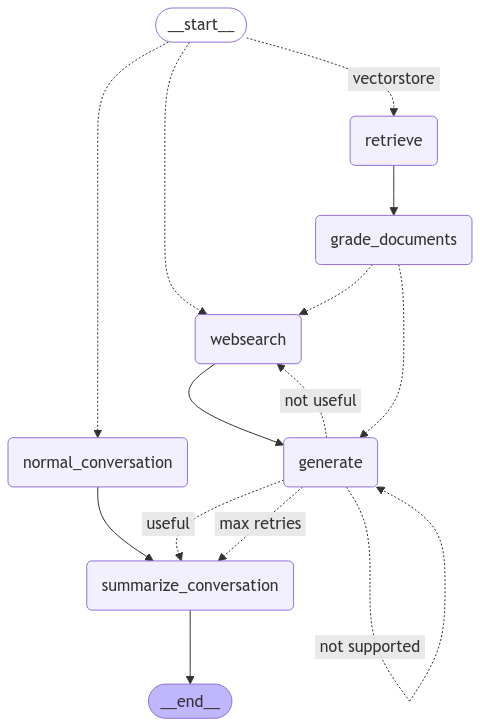

In [ ]:
from langgraph.graph import StateGraph
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
#Ghép các cấu phần

workflow = StateGraph(GraphState)

workflow.add_node("websearch", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("normal_conversation", normal_conversation)
workflow.add_node(summarize_conversation)

workflow.set_conditional_entry_point(
    route_question,
    {
        "normal_conversation": "normal_conversation",
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)

workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": "summarize_conversation",
        "not useful": "websearch",
        "max retries": "summarize_conversation",
    },
)
workflow.add_edge("normal_conversation","summarize_conversation")
workflow.add_edge("summarize_conversation", END)
memory = MemorySaver()
# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "2"}}
mess = HumanMessage(content="ái kỷ là gì")
inputs = {
        "messages": [mess],
        "max_retries": 1,
    }

output = graph.invoke(inputs,config)


---ROUTE QUESTION---
---ROUTE QUESTION TO NORMAL CONVERSATION---


In [ ]:
config = {"configurable": {"thread_id": "2"}}
mess = HumanMessage(content="Nêu các phòng đọc chuyên ngành")
inputs = {
        "messages": [mess],
        "max_retries": 1,
    }

output = graph.invoke(inputs,config)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
---WEB SEARCH---
---GENERATE---
[Document(metadata={}, page_content='Văn bản trong Giới thiệu Thư viện Trường ĐHBK Hà Nội.pdf \n Nội dung như sau: 7. Dịch vụ đọc tài liệu tại chỗ\n ✓ P. 304  phòng đọc luận văn - luận án ✓ P. 404  phòng đọc báo, tạp chí. ✓ 04 Phòng đọc chuyên ngành - P. 402  các sách có phân loại từ A → P - P. 411  các sách có phân loại từ Q → S - P. 419  các sách có phân loại từ T → TJ - P. 526  các sách có phân loại

In [ ]:
output['messages'][-1].content

'Xin chào, tôi là cố vấn học tập của Đại học Bách khoa Hà Nội. Tôi sẵn sàng giúp đỡ bạn trong việc tìm hiểu về các khái niệm và vấn đề khác nhau.\n\n"Ái kỷ" là một thuật ngữ được sử dụng để mô tả một trạng thái tâm lý hoặc một loại tính cách, trong đó một người có xu hướng tự yêu thương, tự quan tâm và tự đặt mình lên trên hết. Ái kỷ có thể được hiểu là một dạng của sự tự yêu thương quá mức, dẫn đến việc một người trở nên quá tập trung vào bản thân, thường bỏ qua hoặc không quan tâm đến cảm xúc và nhu cầu của người khác.\n\nTuy nhiên, cần lưu ý rằng ái kỷ không phải là một khái niệm tâm lý học chính thức được công nhận rộng rãi. Trong tâm lý học, khái niệm gần giống với ái kỷ là "tính cách ái kỷ" (narcissistic personality), được mô tả trong Cẩm nang Chẩn đoán và Thống kê Rối loạn Tâm thần (DSM-5) của Hiệp hội Tâm lý học Mỹ.\n\nNếu bạn muốn tìm hiểu thêm về ái kỷ hoặc các vấn đề tâm lý khác, tôi sẵn sàng giúp đỡ và cung cấp thông tin hữu ích. Hãy cho tôi biết bạn cần giúp đỡ gì!'

In [ ]:
graph.get_state(config).values.get("web_doc","")

[Document(metadata={}, page_content='Quy chế này quy định đào tạo đại học và cao đẳng hệ chính quy theo hệ thống tín chỉ, bao gồm: tổ chức đào tạo; kiểm tra và thi học phần; xét và công nhận tốt nghiệp. ... Sinh viên được chọn tự do theo khối lượng tín chỉ yêu cầu trong chương trình đào tạo. Đối\nKỹ sư Tốt nghiệp THPT 5 năm 156-164 TC ... cho một học phần yêu cầu trong chương trình. Sinh viên học hai học phần tương ... Quy định về học ngành thứ hai đại học chính quy theo học chế tín chỉ. Điều 6. Thời gian và kế hoạch học tập 1. Trường tổ chức đào tạo theo năm\nTrong khi đó, để đáp ứng yêu cầu 150 tín chỉ để cấp bằng kỹ sư, ông Nguyễn Trung Nhân cho biết trường đã điều chỉnh chương trình đào tạo các ngành kỹ thuật lên hơn 150 tín chỉ để có thể tiếp tục cấp bằng kỹ sư cho người học.\nưu hóa thời gian đào tạo cho người học. Chương trình tích hợp cử nhân-kỹ sư có thời gian thiết kế là 5,5 năm và khối lượng học tập 180 TC; bao gồm hai bậc trình độ: Cử nhân (thời gian đào tạo 4 năm, trình độ

In [ ]:
import pandas as pd
faq = pd.read_excel("FAQ.xlsx")
faq

,Câu hỏi,Câu trả lời
0,"Thư viện có các phòng đọc, phòng mượn nào?","04 phòng đọc chuyên ngành tại P.402, P.411, P...."
1,Thư viện mở cửa phục vụ bạn đọc ngoài giờ hành...,"04 Phòng đọc chuyên ngành (402,411,419,526)"
2,Bạn đọc được mượn giáo trình trong thời gian b...,60 ngày
3,Tài liệu phòng mượn giáo trình được dán nhãn m...,Xanh
4,Tiêu chí quan trọng nhất trong quy tắc sắp xếp...,Ký hiệu phân loại (chuyên ngành của tài liệu)
...,...,...
145,Muốn mở thêm lớp trong học kỳ thì sinh viên ph...,Phòng ĐT
146,Muốn đăng ký vào lớp đã đầy thì sinh viên phải...,Khoa/Viện chuyên ngành
147,Sinh viên khi đăng ký học phần thì được gì?,Được đăng ký trong cả hai đợt: chính thức và đ...
148,Đối tượng được đăng ký lớp trong đợt điều chỉn...,Sinh viên chưa đăng ký học phần và đã đăng ký ...


In [ ]:
# Test on current events
import time
states_test = []
i=0
for question in FAQ:
    if i == 2:
      time.sleep(60)
      i = 0
    states_test.append([])
    inputs = {
        "question": question+"\nChọn đáp án đúng",
        "max_retries": 0,
    }

    for event in graph.stream(inputs, stream_mode="values"):
        states_test[-1].append(event)
    i += 1

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
---WEB SEARCH---
---GENERATE---
[Document(metadata={}, page_content='Định luật Parkinson nêu lên mối quan hệ giữa thời hạn và hiệu suất. ... Cyril Northcote Parkinson từng làm việc trong Cơ quan Dân sự Anh và tận mắt chứng kiến cách bộ máy quan liêu tại đây hoạt động. Ông nhận thấy rằng, nếu thời hạn hoàn thành một công việc là 6 tháng\nĐịnh luật Parkinson là một khái niệm bắt nguồn từ công trình của nhà sử học Cyril Northcote Parkinson. Nó gợi ý rằng công việc được mở rộng để lấp đầy thời gian có sẵn để hoàn thành nó. ... Bản chất của công việc và thời gian. Định luật Parkinson chỉ ra một khía\nQuy lu

In [ ]:
messages = []
for state in states_test:
    messages.append({'question': state[-1]['question'],
                     'generation':state[-1]['generation'].content})

In [ ]:
messages

In [ ]:
import pandas as pd
df = pd.DataFrame(messages)
# faq['Câu trả lời của AI'] = df['generation']

In [ ]:
df.head()

,question,generation
0,Trường Đại học Bách khoa Hà Nội được thành lập...,"A. Năm 1956, Chính phủ thành lập Trường Đại họ..."
1,\nHiệu trưởng đầu tiên của Trường là\nA.Thầy T...,"A. \nGiải thích: Theo văn bản, Thiếu tướng, GS..."
2,\nTrường ĐHBK Hà Nội khai giảng khóa 1 ngày nà...,C. Ngày 15/10/1956 \n\nGiải thích: Theo ngữ cả...
3,\nBác Hồ đã về thăm trường ĐHBK Hà Nội mấy lần...,"C. 03 lần \n\nGiải thích: Theo ngữ cảnh, Bác H..."
4,\nTrường ĐHBK Hà Nội mấy lần được phong danh h...,B. Trường ĐHBK Hà Nội được phong danh hiệu Anh...


In [ ]:
df.to_excel("FAiQ.xlsx")